<a href="https://colab.research.google.com/github/Du-nara/ME421-Mechanical-Systems-Lab-A3/blob/main/Vibration/E_20_289_Vibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ME421 – Vibration Modeling Laboratory  
## Week 1: 2-DOF Vibration Analysis (TecQuipment System)

**Objective:**  
- Develop a 2-DOF mathematical model  
- Estimate damping ratios  
- Simulate free and forced vibration responses  

**Apparatus:** TecQuipment Free & Forced Vibration System


## Activity 1 – Derivation of 2-DOF Mathematical Model

### Physical Description
The system consists of:
- A beam pinned at one end
- A spring at the free end
- An unbalanced motor mounted at mid-span

To capture beam flexibility, the system is modeled as a **2-degree-of-freedom (2-DOF)** lumped parameter system.

---

### Generalized Coordinates
- \( x_1(t) \): Vertical displacement at motor location (mid-span)
- \( x_2(t) \): Vertical displacement at beam tip (spring location)

---

### System Parameters
- \( m_1 \): Equivalent mass at motor location
- \( m_2 \): Equivalent mass at beam tip
- \( k_b \): Equivalent bending stiffness of beam
- \( k_s \): Spring stiffness at the beam tip
- \( c_1, c_2 \): Damping coefficients

---

### Equations of Motion

\[
m_1 \ddot{x}_1 + c_1 \dot{x}_1 + k_b(x_1 - x_2) = F(t)
\]

\[
m_2 \ddot{x}_2 + c_2 \dot{x}_2 + k_b(x_2 - x_1) + k_s x_2 = 0
\]

---

### Matrix Form

\[
[M]\{\ddot{x}\} + [C]\{\dot{x}\} + [K]\{x\} = \{F(t)\}
\]

Where,

\[
M = \begin{bmatrix} m_1 & 0 \\ 0 & m_2 \end{bmatrix}
\quad
C = \begin{bmatrix} c_1 & 0 \\ 0 & c_2 \end{bmatrix}
\]

\[
K = \begin{bmatrix}
k_b & -k_b \\
-k_b & k_b + k_s
\end{bmatrix}
\]

---

### Excitation Force (Unbalanced Motor)

\[
F(t) = m_e e \omega^2 \sin(\omega t)
\]

The force acts only at the motor location.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [13]:
# System parameters (assumed / experimentally adjustable)
m1 = 2.0      # kg (motor + beam equivalent)
m2 = 1.5      # kg (beam equivalent)
kb = 2000.0   # N/m (beam stiffness)
ks = 3000.0   # N/m (spring stiffness)

c1 = 5.0      # Ns/m
c2 = 3.0      # Ns/m


In [14]:
M = np.array([[m1, 0],
              [0, m2]])

C = np.array([[c1, 0],
              [0, c2]])

K = np.array([[kb, -kb],
              [-kb, kb + ks]])


## Activity 2 – Estimation of Damping Ratios

### Method 1: Logarithmic Decrement (Time Domain)

\[
\delta = \frac{1}{n} \ln\left(\frac{x_1}{x_{n+1}}\right)
\]

\[
\zeta = \frac{\delta}{\sqrt{4\pi^2 + \delta^2}}
\]

Used mainly for the first vibration mode.

---

### Method 2: Half-Power Bandwidth (Frequency Domain)

\[
\zeta = \frac{\omega_2 - \omega_1}{2\omega_n}
\]

Used for both vibration modes using frequency response data.


In [15]:
def free_vibration(t, y):
    x1, x2, x1_dot, x2_dot = y

    x = np.array([x1, x2])
    x_dot = np.array([x1_dot, x2_dot])

    x_ddot = np.linalg.inv(M) @ (-C @ x_dot - K @ x)

    return [x1_dot, x2_dot, x_ddot[0], x_ddot[1]]


In [16]:
# Initial conditions
y0 = [0.01, 0.0, 0.0, 0.0]  # x1, x2, x1_dot, x2_dot

t_span = (0, 5)
t_eval = np.linspace(0, 5, 1000)

sol = solve_ivp(free_vibration, t_span, y0, t_eval=t_eval)


In [17]:
# Initial conditions
y0 = [0.01, 0.0, 0.0, 0.0]  # x1, x2, x1_dot, x2_dot

t_span = (0, 5)
t_eval = np.linspace(0, 5, 1000)

sol = solve_ivp(free_vibration, t_span, y0, t_eval=t_eval)


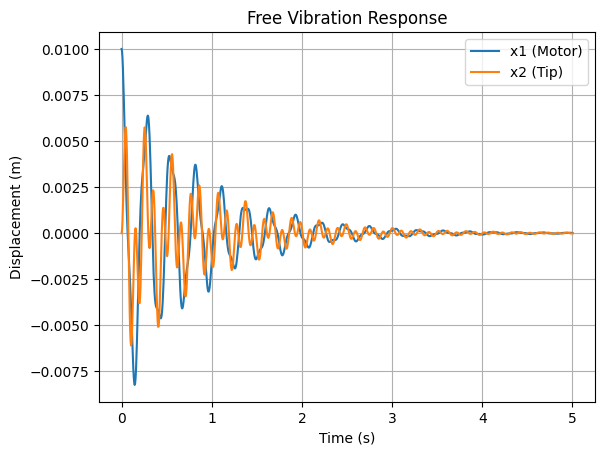

In [18]:
plt.figure()
plt.plot(sol.t, sol.y[0], label='x1 (Motor)')
plt.plot(sol.t, sol.y[1], label='x2 (Tip)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Free Vibration Response')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
me = 0.05     # kg (eccentric mass)
e = 0.02      # m
omega = 30.0  # rad/s

def forced_vibration(t, y):
    x1, x2, x1_dot, x2_dot = y

    F = me * e * omega**2 * np.sin(omega * t)
    force = np.array([F, 0])

    x = np.array([x1, x2])
    x_dot = np.array([x1_dot, x2_dot])

    x_ddot = np.linalg.inv(M) @ (force - C @ x_dot - K @ x)

    return [x1_dot, x2_dot, x_ddot[0], x_ddot[1]]


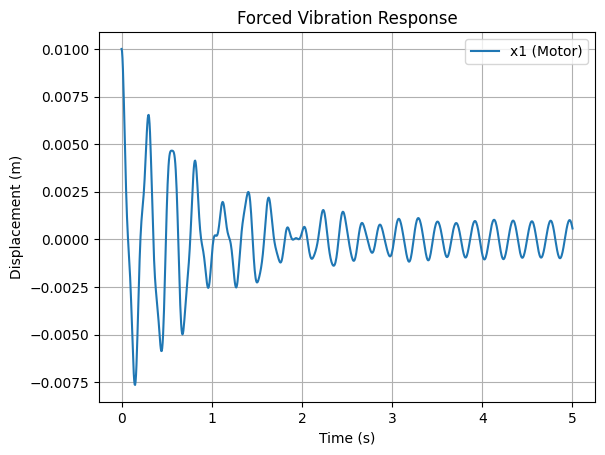

In [20]:
sol_f = solve_ivp(forced_vibration, t_span, y0, t_eval=t_eval)

plt.figure()
plt.plot(sol_f.t, sol_f.y[0], label='x1 (Motor)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Forced Vibration Response')
plt.legend()
plt.grid(True)
plt.show()
